In [1]:
#from ultralytics import YOLO
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

import comet_ml

import json
import os
from PIL import Image
import shutil
import copy

In [2]:
import sys

ultralytics_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked'
sys.path.append(ultralytics_dir)

from ultralytics import YOLO

## To Do
- Debug non-normalized annots
- Validation scores are zero all throughout.  Debug this.
- Find a simple module (like a blob detector) that can be put before the YOLO model.  
    One idea is to do a Spatial Pyriamid Convolution (not pooling), where you take the image, create a few feature maps by running it through different kernel size, giving a fixed image output, which is then used as an input to the model.
    
    Another idea is to use a pretrained blob detector, and input this (or maybe add this to the og image) to the model.


- Find how to add in an initial module.


## Done
- Normalize annotations using the correct image shapes
- Check how the training data and labels should be given to the YOLO model.
- Freezing Layers
- Check if the model resizes image to a standard size.  If so, shouldn't SPPF layer take care of it?
- Load the model using the yaml file.
- Decreased precision of annotations to 4 decimals.  Model training is much quicker.  Previously took >2 mins for 1 epoch, now around 30 seconds.

-----------

## Preprocessing Data

In [3]:
#Parent directory for data
data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data'

#Directories for original data, and data formatted for YOLO
ch_data_dir = data_dir + r'\CrowdHuman'
yolo_ch_data_dir = data_dir + r'\yolo_CrowdHuman'

#Original Data for images
train_dir = ch_data_dir + r'\CrowdHuman_train01\Images'
val_dir = ch_data_dir + r'\CrowdHuman_val\Images'
test_dir = ch_data_dir + r'\CrowdHuman_test\images_test'

#Original Data for annotations
val_annot_odgt = ch_data_dir + r'\annotation_val.odgt'
train_annot_odgt = ch_data_dir + r'\annotation_train.odgt'

#Original Image shapes data
train_shapes_path = data_dir + r'\train_img_shapes.txt'
val_shapes_path = data_dir + r'\val_img_shapes.txt'

#YOLO formatted Training annotations
train_annot_body_dir = yolo_ch_data_dir + r'\train_annots_body'
train_annot_face_dir = yolo_ch_data_dir + r'\train_annots_face'
train_annot_both_dir = yolo_ch_data_dir + r'\train_annots_both'

#YOLO formatted Validation annotations
val_annot_body_dir = yolo_ch_data_dir + r'\val_annots_body'
val_annot_face_dir = yolo_ch_data_dir + r'\val_annots_face'
val_annot_both_dir = yolo_ch_data_dir + r'\val_annots_both'


#YOLO formatted data directory (only body)
data_body_dir = data_dir + r'\yolo_data_body'
data_body_yaml = data_dir + r'\data_body_meta.yaml'

#YOLO formatted data directory (only face)
data_face_dir = data_dir + r'\yolo_data_face'
data_face_yaml = data_dir + r'\data_face_meta.yaml'

#YOLO formatted data directory (both body and face)
data_both_dir = data_dir + r'\yolo_data_both'
data_both_yaml = data_dir + r'\data_both_meta.yaml'

#test_annot_dir = data_dir + r'\test_annot'
#test_shapes_path = data_dir + r'\test_img_shapes.txt'

#### Obtaining Image Shapes

In [3]:
#Obtain list of image shapes from text file, if file does not exist, create the text file
# data_dir: Parent Directory
# shapes_txt: Name of text file to save at
# mode_dir: Type of file (train/val/test)
def get_img_shapes(data_dir, shapes_txt, mode_dir): 

    #Path for the text file
    shapes_path = data_dir + r'\\' + shapes_txt

    #Obtains the image path using the image id
    get_img_path = lambda img_id: ''.join([mode_dir, r'\\', img_id])

    #Obtains the image size using the image id
    #Returns (Image ID, Image Shape): Image Shape = (width, height)
    get_img_shape = lambda img_id: (img_id, Image.open(get_img_path(img_id)).size)

    #Saving to text file
    if shapes_txt not in os.listdir(data_dir):
        print('\nCreating Text File...')
        #Gets image shape for each image in directory
        img_shapes = list(map(get_img_shape, os.listdir(mode_dir)))

        with open(shapes_path, 'w') as f:
            for img_meta in img_shapes:
                f.write(f'{img_meta} \n')
        
        print('Created Text file.\n')


    #Reads the file, extracting the lines
    print('Reading Text File...')
    with open(shapes_path, 'r') as f:
        file_shapes = f.readlines()
    
    #Extracts information from each line (of type string)
    def get_info_from_str(s):
        s = s.strip().split(', ')
        return [s[0][2:-5], float(s[1][1:]), float(s[2][:-2])]

    img_shapes = list(map(get_info_from_str, file_shapes))

    return(img_shapes)

In [4]:
train_img_shapes = get_img_shapes(data_dir, shapes_txt = r'train_img_shapes.txt', mode_dir = train_dir)
val_img_shapes = get_img_shapes(data_dir, shapes_txt = r'val_img_shapes.txt', mode_dir = val_dir)
test_img_shapes = get_img_shapes(data_dir, shapes_txt = r'test_img_shapes.txt', mode_dir = test_dir)

Reading Text File...
Reading Text File...
Reading Text File...


In [5]:
train_img_shapes[:5]

[['273271,1017c000ac1360b7', 6567.0, 3888.0],
 ['273271,10355000e3a458a6', 600.0, 400.0],
 ['273271,1039400091556057', 1993.0, 2274.0],
 ['273271,1050b000e40d8e93', 700.0, 700.0],
 ['273271,105b40008a7b8b1f', 1600.0, 1067.0]]

#### Annotations from .odgt to .txt

In [6]:
def convert_to_yolo_format(box, img_width, img_height, precision = 4):
    """
    Convert bounding box annotation to YOLO format.
    """

    #x_bl, y_bl refers to bottom left corner
    x_bl, y_bl, width, height = box

    x_center = (x_bl + width / 2) / img_width
    y_center = (y_bl + height / 2) / img_height
    width /= img_width
    height /= img_height

    #Decreases the precision to 4 decimal digits to make the model training lighter
    x_center, y_center, width, height = list(map(lambda n: round(n, precision), [x_center, y_center, width, height]))
    
    return x_center, y_center, width, height

In [7]:
def process_annotations(odgt_file, output_dir, img_shapes, bbox_mode):

    output_dir = output_dir + '_' + bbox_mode

    #Create directory
    if not os.path.exists(output_dir): os.makedirs(output_dir)

    #Get image ids using the img_shapes list ([Image ID, Image Shape])
    img_ids = [meta[0] for meta in img_shapes]

    #Read annotation file
    with open(odgt_file, 'r') as f:
        lines = f.readlines()

    #Iterate through each line, which contains the json formatted info for each image
    for line in lines:
        annotation = json.loads(line)   #Get the JSON formatted annotation
        image_id = annotation['ID']     #Image ID
        objects = annotation['gtboxes'] #Bounding Boxes

        if image_id not in img_ids: continue    #Filtering out unnecessary training samples

        img_index = img_ids.index(image_id)     #Get index of the required image
        img_width, img_height = img_shapes[img_index][1], img_shapes[img_index][2]  #Get shape of required image
        
        yolo_labels = []
        for obj in objects:
            
            # Skip ignored boxes
            if obj['extra'].get('ignore', 0) == 1: continue

            # Assuming the class label for the body bounding box is 0
            # and the class label for the face bounding box is 1
            body_box = obj['vbox']  # Visible bounding box
            face_box = obj['hbox']  # Head bounding box
            
            #Convert to yolo format
            body_yolo = convert_to_yolo_format(body_box, img_width, img_height)
            face_yolo = convert_to_yolo_format(face_box, img_width, img_height)

            #Append annots to yolo_labels
            if bbox_mode == 'face':  yolo_labels.append((80, *face_yolo))    #Class 80 for face
            elif bbox_mode == 'body': yolo_labels.append((0, *body_yolo))    #Class 0 for body
            elif bbox_mode == 'both':
                yolo_labels.append((0, *body_yolo))
                yolo_labels.append((80, *face_yolo))
            else:
                return('Invalid entry for mode.  Only accepted values: ["face", "body", "both"]')

        # Write YOLO format annotations to file
        label_filename = os.path.join(output_dir, f"{image_id}.txt")
        with open(label_filename, 'w') as out_f:
            for label in yolo_labels:
                out_f.write(" ".join(map(str, label)) + '\n')

In [19]:
# Convert training annotations to folder with annotated text files
idgt_file = train_annot_odgt
output_dir = yolo_ch_data_dir + r'\train_annots'

process_annotations(idgt_file, output_dir, train_img_shapes, bbox_mode = 'both')

In [20]:
# Convert training annotations to folder with annotated text files
idgt_file = val_annot_odgt
output_dir = yolo_ch_data_dir + r'\val_annots'

process_annotations(idgt_file, output_dir, val_img_shapes, bbox_mode = 'both')

In [15]:
len(os.listdir(val_dir))

4370

In [22]:
len(os.listdir(val_annot_both_dir))

4370

#### Plotting Image

(768, 1024, 3)


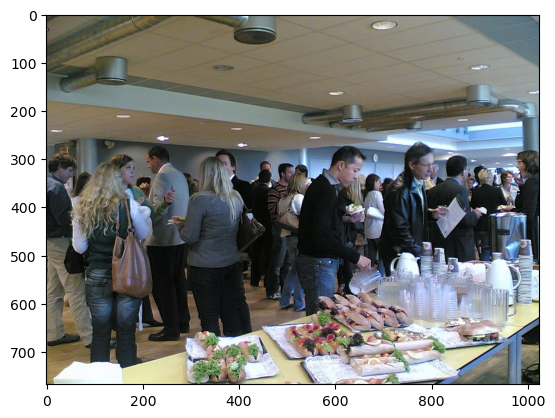

In [127]:
#Get sample image
image_ind = 15

sample_img_file = os.listdir(train_dir)[image_ind]
sample_img_path = train_dir + fr'\{sample_img_file}'
sample_img = cv2.imread(sample_img_path)
print(sample_img.shape)

plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [132]:
#Get the bounding boxes
sample_img_id = sample_img_file[:-4]
sample_annot_path = train_annot_face_dir + f'\{sample_img_id}.txt'

with open(sample_annot_path, 'r') as f:
    sample_annots = f.readlines()

In [134]:
#Get shape of image
img_ids = [meta[0] for meta in train_img_shapes]
sample_ind = img_ids.index(sample_img_id)
sample_img_shape = train_img_shapes[sample_ind][1:]
sample_img_shape

[1024.0, 768.0]

In [135]:
#Get bounding boxes (both visible and face boxes)
get_info = lambda s: [float(val) for val in s.strip().split(' ')[1:]]
sample_img_bboxs = list(map(get_info, sample_annots))

sample_img_bboxs[1]

[0.0361328125, 0.4147135416666667, 0.064453125, 0.08984375]

In [72]:
#Obtain the plotting coords using the bounding box values
def get_plt_coords(bbox, img_width = None, img_height = None):
    x, y, w, h = bbox

    if img_width and img_height:
        x, y, w, h = x*img_width, y*img_height, w*img_width, h*img_height

    #x, y are centered
    return([[[x - w/2, x + w/2], [y - h/2, y - h/2]],
            [[x - w/2, x + w/2], [y + h/2, y + h/2]],
            [[x - w/2, x - w/2], [y - h/2, y + h/2]],
            [[x + w/2, x + w/2], [y - h/2, y + h/2]]])

In [137]:
coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img_shape[0], sample_img_shape[1]), sample_img_bboxs))
np.shape(coords)

(20, 4, 2, 2)

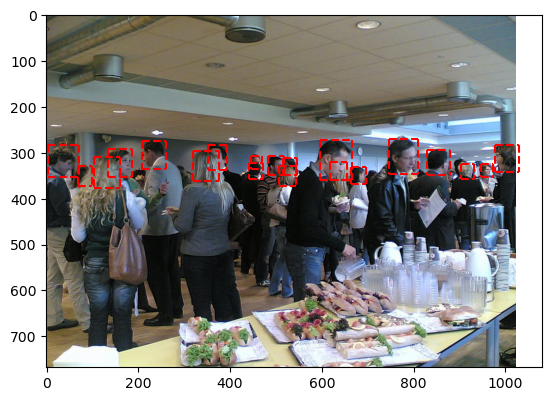

In [138]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

for coord in coords:
    for c in coord:
        plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

#### Creating dirs in YOLO format

In [53]:
n_train, n_val = 4, 4

In [54]:
def shift_files(source_dir, dest_dir, n_files, data_image, mode_train):

    #If data files is images or annotations
    if data_image: dest_dir += r'\images'
    else: dest_dir += r'\labels'

    #If data files is for training or validation
    if mode_train: dest_dir += r'\train'
    else: dest_dir += r'\val'

    #Creates destination directory (overwrites if exists)
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    #Gets files to shift
    shift_files = os.listdir(source_dir)[:n_files]

    #Copies files from source to destination
    for file_name in shift_files:
        file_path = os.path.join(source_dir, file_name)

        if os.path.isfile(file_path):
            shutil.copy(file_path, dest_dir)

    dest_dir_split = dest_dir.split('\\')
    print(f'Finished Copying {n_files} {dest_dir_split[-1]} {dest_dir_split[-2]}')

In [55]:
#For only body annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_body_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_body_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_body_dir, dest_dir = data_body_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_body_dir, dest_dir = data_body_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 4 train images
Finished Copying 4 val images
Finished Copying 4 train labels
Finished Copying 4 val labels


In [56]:
#For only face annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_face_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_face_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_face_dir, dest_dir = data_face_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_face_dir, dest_dir = data_face_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 4 train images
Finished Copying 4 val images
Finished Copying 4 train labels
Finished Copying 4 val labels


In [57]:
#For both body and face annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_both_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_both_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_both_dir, dest_dir = data_both_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_both_dir, dest_dir = data_both_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 4 train images
Finished Copying 4 val images
Finished Copying 4 train labels
Finished Copying 4 val labels


#### Plotting YOLO formatted data

In [25]:
sample_ind = 3

sample_img_path = data_face_dir + r'\images\train'
sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
sample_img = cv2.imread(sample_img_path)

sample_label_path = data_face_dir + r'\labels\train'
sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

with open(sample_label_path, 'r') as f:
    sample_label = f.readlines()

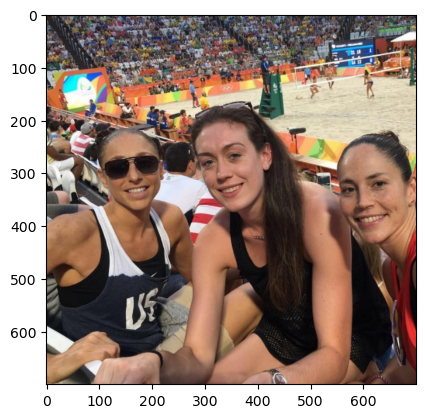

In [13]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [132]:
conv_to_floats = lambda row: [float(elem) for pos, elem in enumerate(row.strip().split(' ')) if pos != 0]

sample_label = list(map(conv_to_floats, sample_label))
coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img.shape[1], sample_img.shape[0]), sample_label))

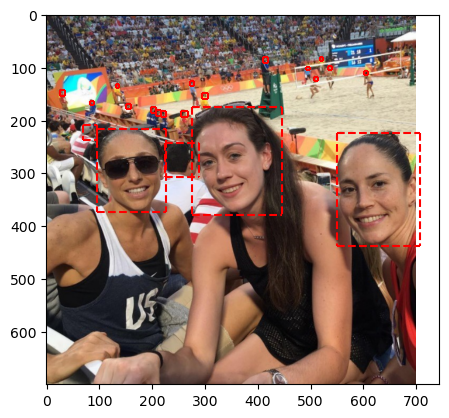

In [133]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

for coord in coords:
    for c in coord:
        plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

#### Rough

In [78]:
with open(train_annot_odgt, 'r') as f:
    file = f.readlines()

In [82]:
json.loads(file[0])['gtboxes']

[{'tag': 'person',
  'hbox': [123, 129, 63, 64],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [61, 123, 191, 453],
  'vbox': [62, 126, 154, 446],
  'extra': {'box_id': 0, 'occ': 1}},
 {'tag': 'person',
  'hbox': [214, 97, 58, 74],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [165, 95, 187, 494],
  'vbox': [175, 95, 140, 487],
  'extra': {'box_id': 1, 'occ': 1}},
 {'tag': 'person',
  'hbox': [318, 109, 58, 68],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [236, 104, 195, 493],
  'vbox': [260, 106, 170, 487],
  'extra': {'box_id': 2, 'occ': 1}},
 {'tag': 'person',
  'hbox': [486, 119, 61, 74],
  'head_attr': {'ignore': 0, 'occ': 0, 'unsure': 0},
  'fbox': [452, 110, 169, 508],
  'vbox': [455, 113, 141, 501],
  'extra': {'box_id': 3, 'occ': 1}},
 {'tag': 'person',
  'hbox': [559, 105, 53, 57],
  'head_attr': {'ignore': 0, 'occ': 0, 'unsure': 0},
  'fbox': [520, 95, 163, 381],
  'vbox': [553, 98, 70, 118],
  'extra': {'box_id': 4, 'occ'

## YOLOv8

In [4]:
# Load the pretrained YOLOv8 model
#model = YOLO('yolov8n.pt')

model_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n.yaml'
weights_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\Vision_Project\yolov8n.pt'

coco8_yaml = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\datasets\coco8.yaml'

model = YOLO(model_dir).load(weights_dir)

Transferred 355/355 items from pretrained weights


#### Sample Run

In [ ]:
# Load an image
image_path = 'test_image.jpeg'
image = cv2.imread(image_path)

# Perform inference
results = model(image)

In [59]:
img_annot = results[0].plot()
plt.imshow(cv2.cvtColor(img_annot, cv2.COLOR_BGR2RGB))
#plt.show()

In [60]:
# Access detection results

box_dims = {}

for result in results:
    boxes = result.boxes
    for n_box, box in enumerate(boxes):
        x1, y1, x2, y2 = box.xyxy[0]
        confidence = box.conf[0]
        class_id = box.cls[0]
        print(f"Class ID: {class_id}, Confidence: {confidence}, BBox: [{x1}, {y1}, {x2}, {y2}]")

        box_dims[n_box] = [float(class_id), float(confidence), box.xyxy[0].numpy()]

Class ID: 0.0, Confidence: 0.8936586976051331, BBox: [1027.455078125, 224.96200561523438, 1615.25, 1054.39013671875]
Class ID: 2.0, Confidence: 0.7256653308868408, BBox: [80.91741943359375, 446.79302978515625, 1597.1224365234375, 1068.33544921875]


#### Pre-Model Layer: Hough Circle Transform

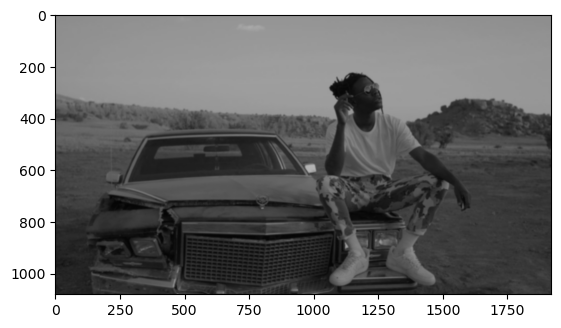

In [23]:
# Load the image
image = cv2.imread('test_image.jpeg', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a Gaussian blur to reduce noise and improve edge detection
gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

plt.imshow(cv2.cvtColor(gray_blurred, cv2.COLOR_BGR2RGB))

In [24]:
# Use the Hough Circle Transform to detect circles
circles = cv2.HoughCircles(
    gray_blurred, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2, 
    minDist=30,
    param1=50,
    param2=30,
    minRadius=15,
    maxRadius=50
)

In [26]:
# If some circles are detected, let's highlight them
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

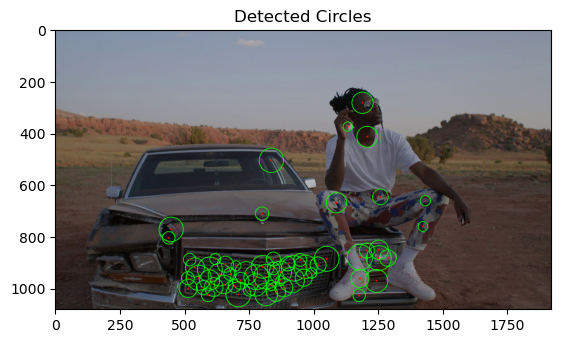

In [27]:
# Display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.show()

#### Pre-Model Layer: SPPF

In [10]:
model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

#### Pre-Model Layer

In [4]:
param_state_dict = model.state_dict()
param_state_dict

OrderedDict([('model.model.0.conv.weight',
              tensor([[[[-1.1523e-01, -1.0582e-02,  1.0693e-01],
                        [-3.6816e-01,  3.3447e-02,  3.8745e-01],
                        [-3.3716e-01, -1.3680e-02,  3.1201e-01]],
              
                       [[-1.4233e-01,  9.7656e-03,  1.5222e-01],
                        [-4.8999e-01,  2.7908e-02,  4.6021e-01],
                        [-3.7256e-01, -2.7542e-03,  3.4814e-01]],
              
                       [[-4.9866e-02, -1.4900e-02,  2.4887e-02],
                        [-2.1375e-01,  3.2898e-02,  1.9385e-01],
                        [-1.5344e-01,  3.1113e-02,  1.5649e-01]]],
              
              
                      [[[ 1.2283e-02,  1.8890e-02,  8.2321e-03],
                        [-2.7218e-03, -2.3987e-02,  2.9926e-03],
                        [-1.7059e-02, -1.4148e-01, -1.7426e-02]],
              
                       [[-9.5062e-03,  1.2146e-02,  8.6975e-04],
                        [-7.3242

In [11]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class ImgBlob(nn.Module):

    def __init__(self, c_in, c_mid, k=3, s=1, p=None, d=1):
        super().__init__()

        self.conv1 = nn.Conv2d(c_in, c_mid, k, s, autopad(k, p, d), dilation = d)
        self.conv2 = nn.Conv2d(c_mid, c_in, k, s, autopad(k, p, d), dilation = d)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return(x)

--------------

In [48]:
check = ImgBlob(3, 5, 3)
check

ImgBlob(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [65]:
import re
import yaml

In [62]:
def yaml_load(file="data.yaml", append_filename=False):

    with open(file, errors="ignore", encoding="utf-8") as f:
        s = f.read()  # string

        # Remove special characters
        if not s.isprintable():
            s = re.sub(r"[^\x09\x0A\x0D\x20-\x7E\x85\xA0-\uD7FF\uE000-\uFFFD\U00010000-\U0010ffff]+", "", s)

        # Add YAML filename to dict and return
        data = yaml.safe_load(s) or {}  # always return a dict (yaml.safe_load() may return None for empty files)
        if append_filename:
            data["yaml_file"] = str(file)
        return data

In [67]:
yaml_dict = yaml_load(model_trial_dir)
d = copy.deepcopy(yaml_dict)
d

{'nc': 80,
 'backbone': [[-1, 1, 'ImgBlob', [3, 5, 3]],
  [-1, 1, 'Conv', [64, 3, 2]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [-1, 3, 'C2f', [128, True]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [-1, 6, 'C2f', [256, True]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [-1, 6, 'C2f', [512, True]],
  [-1, 1, 'Conv', [1024, 3, 2]],
  [-1, 3, 'C2f', [1024, True]],
  [-1, 1, 'SPPF', [1024, 5]]],
 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 6], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 4], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [256]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [[-1, 12], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [[-1, 9], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [1024]],
  [[15, 18, 21], 1, 'Detect', ['nc']]]}

In [70]:
for i, (f, n, m, args) in enumerate(d["backbone"] + d["head"]): break

In [71]:
print(f, n, m, args)

-1 1 ImgBlob [3, 5, 3]


--------------------

In [22]:
model = YOLO(model_dir).load(weights_dir)

Transferred 355/355 items from pretrained weights


In [24]:
len(model.state_dict())

355

In [46]:
def get_layer_sizes(state_dict):

    get_layer_num = lambda name: int(name.split('.')[2])
    n_layers = get_layer_num( list(state_dict.keys())[-1] ) + 1

    layer_sizes = {}

    for layer_num in range(n_layers):
        
        param_names = [name for name in state_dict.keys() if get_layer_num(name) == layer_num]
        layer_sizes[layer_num] = [(param, state_dict[param].shape) for param in param_names]
    
    return(layer_sizes)

    

In [69]:
layer_sizes = get_layer_sizes(model.state_dict())
layer_sizes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [70]:
for k, v in layer_sizes.items():
    print(f'\n\n Layer {k}')

    for t in v:
        print(f'{t[0]}: {t[1]}\n')



 Layer 0
model.model.0.conv.weight: torch.Size([16, 3, 3, 3])

model.model.0.bn.weight: torch.Size([16])

model.model.0.bn.bias: torch.Size([16])

model.model.0.bn.running_mean: torch.Size([16])

model.model.0.bn.running_var: torch.Size([16])

model.model.0.bn.num_batches_tracked: torch.Size([])



 Layer 1
model.model.1.conv.weight: torch.Size([32, 16, 3, 3])

model.model.1.bn.weight: torch.Size([32])

model.model.1.bn.bias: torch.Size([32])

model.model.1.bn.running_mean: torch.Size([32])

model.model.1.bn.running_var: torch.Size([32])

model.model.1.bn.num_batches_tracked: torch.Size([])



 Layer 2
model.model.2.cv1.conv.weight: torch.Size([32, 32, 1, 1])

model.model.2.cv1.bn.weight: torch.Size([32])

model.model.2.cv1.bn.bias: torch.Size([32])

model.model.2.cv1.bn.running_mean: torch.Size([32])

model.model.2.cv1.bn.running_var: torch.Size([32])

model.model.2.cv1.bn.num_batches_tracked: torch.Size([])

model.model.2.cv2.conv.weight: torch.Size([32, 48, 1, 1])

model.model.2.c

In [67]:
layer_sizes = get_layer_sizes(model_trial.state_dict())
layer_sizes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [68]:
for k, v in layer_sizes.items():
    print(f'\n\n  {k}')

    for t in v:
        print(f'{t[0]}: {t[1]}\n')



 Layer 0
model.model.0.conv1.weight: torch.Size([5, 3, 3, 3])

model.model.0.conv2.weight: torch.Size([3, 5, 3, 3])



 Layer 1
model.model.1.conv.weight: torch.Size([16, 3, 3, 3])

model.model.1.bn.weight: torch.Size([16])

model.model.1.bn.bias: torch.Size([16])

model.model.1.bn.running_mean: torch.Size([16])

model.model.1.bn.running_var: torch.Size([16])

model.model.1.bn.num_batches_tracked: torch.Size([])



 Layer 2
model.model.2.conv.weight: torch.Size([32, 16, 3, 3])

model.model.2.bn.weight: torch.Size([32])

model.model.2.bn.bias: torch.Size([32])

model.model.2.bn.running_mean: torch.Size([32])

model.model.2.bn.running_var: torch.Size([32])

model.model.2.bn.num_batches_tracked: torch.Size([])



 Layer 3
model.model.3.cv1.conv.weight: torch.Size([32, 32, 1, 1])

model.model.3.cv1.bn.weight: torch.Size([32])

model.model.3.cv1.bn.bias: torch.Size([32])

model.model.3.cv1.bn.running_mean: torch.Size([32])

model.model.3.cv1.bn.running_var: torch.Size([32])

model.model.3

In [ ]:
for (_, v_model), (_, v_trial) in zip()

In [51]:
def rand_conv_weights(in_channels, out_channels, kernel_size):
    tensor_shape = (out_channels, in_channels, kernel_size[0], kernel_size[0])
    return torch.rand(tensor_shape)

get_param_name = lambda layer_num, param_name: f'model.model.{layer_num}.{param_name}.weight'

In [52]:
new_state_dict = {}

new_state_dict[get_param_name(0, 'conv1')] = rand_conv_weights(in_channels=3, out_channels=5, kernel_size=(3, 3))
new_state_dict[get_param_name(0, 'conv2')] = rand_conv_weights(in_channels=5, out_channels=3, kernel_size=(3, 3))
new_state_dict.keys()

dict_keys(['model.model.0.conv1.weight', 'model.model.0.conv2.weight'])

In [53]:
new_state_dict.keys()

dict_keys(['model.model.0.conv1.weight', 'model.model.0.conv2.weight'])

In [54]:
param_state_dict = model.state_dict()

for param_name, param_val in param_state_dict.items():
    layer_val = int(param_name.split('.')[2])
    new_param_name = param_name.replace(f'model.model.{layer_val}', f'model.model.{layer_val + 1}')

    new_state_dict[new_param_name] = param_state_dict[param_name]

In [56]:
layer_sizes = get_layer_sizes(new_state_dict)
layer_sizes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [57]:
for k, v in layer_sizes.items():
    print(f'\n\n {k}, {len(v)}')



 0, 2


 1, 6


 2, 6


 3, 24


 4, 6


 5, 36


 6, 6


 7, 36


 8, 6


 9, 24


 10, 12


 11, 0


 12, 0


 13, 24


 14, 0


 15, 0


 16, 24


 17, 6


 18, 0


 19, 24


 20, 6


 21, 0


 22, 24


 23, 85


In [58]:
torch.save(new_state_dict, 'yolov8n_trial.pt')

-------------

In [5]:
model_trial_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n_trial.yaml'
weights_trial_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\Vision_Project\yolov8n_trial.pt'

In [22]:
model_trial = YOLO(model_trial_dir, task = 'detect')#.load(weights_trial_dir)

In [23]:
model_trial

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): ImgBlob(
        (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (3): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): Si

In [25]:
model_trial.state_dict().keys()

odict_keys(['model.model.0.conv1.weight', 'model.model.0.conv2.weight', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.conv.weight', 'model.model.2.bn.weight', 'model.model.2.bn.bias', 'model.model.2.bn.running_mean', 'model.model.2.bn.running_var', 'model.model.2.bn.num_batches_tracked', 'model.model.3.cv1.conv.weight', 'model.model.3.cv1.bn.weight', 'model.model.3.cv1.bn.bias', 'model.model.3.cv1.bn.running_mean', 'model.model.3.cv1.bn.running_var', 'model.model.3.cv1.bn.num_batches_tracked', 'model.model.3.cv2.conv.weight', 'model.model.3.cv2.bn.weight', 'model.model.3.cv2.bn.bias', 'model.model.3.cv2.bn.running_mean', 'model.model.3.cv2.bn.running_var', 'model.model.3.cv2.bn.num_batches_tracked', 'model.model.3.m.0.cv1.conv.weight', 'model.model.3.m.0.cv1.bn.weight', 'model.model.3.m.0.cv1.bn.bias', 'model.model.3.m.0.cv1.bn.runni

In [9]:
model_trial.load_state_dict(torch.load(weights_trial_dir))

<All keys matched successfully>

In [76]:
list(model.named_parameters())

[('model.model.0.conv.weight',
  Parameter containing:
  tensor([[[[-1.1523e-01, -1.0582e-02,  1.0693e-01],
            [-3.6816e-01,  3.3447e-02,  3.8745e-01],
            [-3.3716e-01, -1.3680e-02,  3.1201e-01]],
  
           [[-1.4233e-01,  9.7656e-03,  1.5222e-01],
            [-4.8999e-01,  2.7908e-02,  4.6021e-01],
            [-3.7256e-01, -2.7542e-03,  3.4814e-01]],
  
           [[-4.9866e-02, -1.4900e-02,  2.4887e-02],
            [-2.1375e-01,  3.2898e-02,  1.9385e-01],
            [-1.5344e-01,  3.1113e-02,  1.5649e-01]]],
  
  
          [[[ 1.2283e-02,  1.8890e-02,  8.2321e-03],
            [-2.7218e-03, -2.3987e-02,  2.9926e-03],
            [-1.7059e-02, -1.4148e-01, -1.7426e-02]],
  
           [[-9.5062e-03,  1.2146e-02,  8.6975e-04],
            [-7.3242e-03, -2.6993e-02, -5.9357e-03],
            [-2.0844e-02, -1.4062e-01, -2.2461e-02]],
  
           [[-1.9436e-03,  4.3182e-03, -3.6392e-03],
            [ 3.4027e-03, -8.4229e-03,  6.2981e-03],
            [ 1.0201

In [17]:
state_dict = model_trial.state_dict()

layer_sizes = {int(name.split('.')[2]): [(name, state_dict[name])]  for name in state_dict.keys()}
len(layer_sizes)

18

In [19]:
layer_sizes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 19, 20, 22, 23])

In [ ]:
layer_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 19, 20, 22, 23]

In [16]:
get_first_elems = lambda l: [t[0] for t in l]
get_sec_elems = lambda l: [t[1] for t in l]

layer_param_names = get_first_elems(layer_sizes[0])
layer_param_names

['model.model.0.conv2.weight']

#### Freezing Layers

<b>Disabling Batch Normalization:</b> When freezing layers, the parameters can get frozen however the batch normalization stats can still update.  This is seen below when comparing the state dicts before and after the training where we froze 22 layers but the bn sections of these frozen layers are still seen to be updating.  To deal with this, we need to define a callback function that disables the tracking of stats.

In [10]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

From the model architecture, we see that the backbone consists of the first 10 layers, the neck consists of the 12 layers after, and the head is the last layer.  This gives a total of 23 layers for the module.

In [11]:
model = model_trial

In [16]:
int(list(model.state_dict().keys())[-1].split('.')[2])

23

In [15]:
model.state_dict().keys()

odict_keys(['model.model.0.conv1.weight', 'model.model.0.conv2.weight', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.conv.weight', 'model.model.2.bn.weight', 'model.model.2.bn.bias', 'model.model.2.bn.running_mean', 'model.model.2.bn.running_var', 'model.model.2.bn.num_batches_tracked', 'model.model.3.cv1.conv.weight', 'model.model.3.cv1.bn.weight', 'model.model.3.cv1.bn.bias', 'model.model.3.cv1.bn.running_mean', 'model.model.3.cv1.bn.running_var', 'model.model.3.cv1.bn.num_batches_tracked', 'model.model.3.cv2.conv.weight', 'model.model.3.cv2.bn.weight', 'model.model.3.cv2.bn.bias', 'model.model.3.cv2.bn.running_mean', 'model.model.3.cv2.bn.running_var', 'model.model.3.cv2.bn.num_batches_tracked', 'model.model.3.m.0.cv1.conv.weight', 'model.model.3.m.0.cv1.bn.weight', 'model.model.3.m.0.cv1.bn.bias', 'model.model.3.m.0.cv1.bn.runni

In [17]:
#Get number of parameters in a layer
def get_layer_params(layer_num, model):
    
    params = []
    for k, v in model.named_parameters():   #Gets (name of param, value of param)
        if f'model.{layer_num}.' in k:      #Extracts params corresponding to model layer
            params.append(v)                #Appends layer params to list

    return(sum([p.numel() for p in params]))    #Returns total number of params in layer

n_layers = int(list(model.state_dict().keys())[-1].split('.')[2])


#Gets the number of trainable params after freezing n_freeze layers (freezing from 0 till (n_freeze - 1), the n_freeze layer is not frozen)
n_params_after_freeze = lambda n_freeze, model: sum(list(map(lambda layer_num: get_layer_params(layer_num, model), np.arange(n_freeze, n_layers + 1))))

print(f'Total number of parameters: {n_params_after_freeze(0, model)}\n')
print(f'Trainable params after freezing backbone: {n_params_after_freeze(10, model)}')
print(f'Trainable params after freezing half of neck: {n_params_after_freeze(15, model)}')
print(f'Trainable params after freezing neck: {n_params_after_freeze(22, model)}')
print(f'Trainable params after freezing head: {n_params_after_freeze(23, model)}')

Total number of parameters: 3157470

Trainable params after freezing backbone: 2049152
Trainable params after freezing half of neck: 1736320
Trainable params after freezing neck: 1390720
Trainable params after freezing head: 897664


In [18]:
#Freezes layers for fine-tuning
def freeze_layer(trainer, freeze_layers):

    model = trainer.model

    #Prints the layers being frozen
    print(f'\nFreezing {len(freeze_layers)} layers: \n {freeze_layers}\n')
    freeze = [f'model.{x}.' for x in freeze_layers]

    #Iterates through all params
    for param_name, param in model.named_parameters():
        param.requires_grad = True  #Sets all params to trainable

        #Sets params belonging to freeze layers as non-trainable (freezing them)
        if any(x in param_name for x in freeze):
            param.requires_grad = False
    
    print(f'{len(freeze_layers)} layers are freezed')
    print(f'Total number of trainable parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}\n')

In [19]:
#Disables tracking batch normalization stats, puts bn layers to eval mode
def put_layer_in_eval_mode(trainer, freeze_layers):

    track_layers = []

    #Gets modules for batch normalization, checks if it belongs to a frozen layer
    #If so, it puts the module to eval mode and disables bn stats tracking
    for (name, module) in trainer.model.named_modules():
        if name.endswith('bn') and int(name.split('.')[1]) in freeze_layers:
            module.eval()
            module.track_running_stats = False

            #print(f'{name} put in eval mode')

            #layer_num = int(name.split('.')[1])
            #if layer_num not in track_layers: track_layers.append(layer_num)
    
    #print(f'\nFollowing layers with batch normalization put into eval mode: \n {track_layers} \n')

In [20]:
#Define number of layers to be frozen

#Freezing first n layers (excluding the nth layer)
freeze_layers = np.arange(1, 24)

# #Freezing Backbone
# freeze_layers = np.arange(10)

# #Freezing Backbone + Neck
# freeze_layers = np.arange(22)

# # Freezing Backbone + Head
# freeze_layers = np.concatenate((np.arange(10), np.array([22])), axis = 0)



#Define callback with freezing layers
model.add_callback("on_train_start", lambda trainer: freeze_layer(trainer, freeze_layers))

#Define callback for putting bn layers to eval mode
model.add_callback("on_train_epoch_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))
model.add_callback("on_pretrain_routine_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))

#Define the baseline state dict for params
params_init_state = copy.deepcopy(model.state_dict())

In [27]:
coco8_results = model.train(data = coco8_yaml, epochs = 30, save = True, name = 'train_coco8', exist_ok = True, verbose = False)

New https://pypi.org/project/ultralytics/8.2.51 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.50  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n_trial.yaml, data=C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\datasets\coco8.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train_coco8, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, so

train: Scanning C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\Vision_Cognitive_Systems\Project\datasets\coco8\labels\train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
val: Scanning C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\Vision_Cognitive_Systems\Project\datasets\coco8\labels\val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to runs\detect\train_coco8\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 66 weight(decay=0.0005), 63 bias(decay=0.0)

Freezing 23 layers: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

23 layers are freezed
Total number of trainable parameters: 270

Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train_coco8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.762      5.691      4.265         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.794      5.652       4.25         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      3.244      5.927      4.294         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.976      5.657      4.287         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G       3.11      6.045      4.243         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      3.192      5.792      4.327         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      3.169      5.868      4.303         13        640: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      3.112      6.079      4.209         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      2.995      5.673      4.251         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      2.916      5.842      4.289         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      3.197      5.604      4.237         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      2.662      5.783       4.27         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      3.141      5.795      4.217         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      3.005      6.003      4.585         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      2.757      5.609      4.331         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      3.085      5.828      4.309         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      2.875      5.675      4.259         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      3.218      5.748      4.286         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      2.802      5.703      4.326         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      2.628      6.224      4.392         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          4         17          0          0          0          0


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G       2.66      5.763      4.221         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      3.163      6.023      4.223         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      2.781      5.631      4.281         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      2.695      5.708      4.344         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      2.437       5.64      4.311         12        640: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      3.044      5.874      4.219         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      3.122      5.673      4.314         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      2.457      5.791      4.372         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      3.149      5.792      4.447         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G          3       5.83      4.271         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          4         17          0          0          0          0



30 epochs completed in 0.023 hours.
Optimizer stripped from runs\detect\train_coco8\weights\last.pt, 6.6MB
Optimizer stripped from runs\detect\train_coco8\weights\best.pt, 6.6MB

Validating runs\detect\train_coco8\weights\best.pt...
Ultralytics YOLOv8.2.50  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
YOLOv8n_trial summary (fused): 171 layers, 3152174 parameters, 0 gradients, 9.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          4         17          0          0          0          0


Speed: 2.1ms preprocess, 121.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train_coco8


In [169]:
results = model.train(data = data_body_yaml,
                                verbose = False,
                                imgsz = 640,
                                epochs = 30, patience = 3, batch = 64,
                                #freeze = 10,
                                name = 'train_t10_v5', exist_ok = True,
                                cache = True,
                                single_cls = True,
                                box = 7.5, cls = 0.5,
                                pose = 0, kobj = 0,
                                val = True, plots = True)

New https://pypi.org/project/ultralytics/8.2.51 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.46  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n.yaml, data=E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\data_body_meta.yaml, epochs=30, time=None, patience=3, batch=64, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=0, project=None, name=train_t10_v5, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=Tru

train: Scanning E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\labels\train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
train: Caching images (0.0GB RAM): 100%|██████████| 4/4 [00:00<00:00, 13.93it/s]
val: Scanning E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\labels\val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 4/4 [00:00<00:00, 202.31it/s]

Plotting labels to runs\detect\train_t10_v5\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)

Freezing 22 layers: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

22 layers are freezed
Total number of trainable parameters: 897664


Freezing 22 layers: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

22 layers are freezed
Total number of trainable parameters: 897664


Freezing 22 layers: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

22 layers are freezed
Total number of trainable parameters: 897664


Freezing 22 layers: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

22 layers are freezed
Total number of trainable parameters: 897664

Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ru

       1/30         0G      1.488      1.414      1.301         62        640: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all          4         67      0.744      0.433      0.541      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.694      1.749       1.59         60        640: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          4         67      0.745      0.433      0.541      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G       1.58      1.414      1.423         63        640: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         67      0.744      0.433      0.541      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.921      1.398      1.642         61        640: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          4         67      0.745      0.433      0.542      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.698      1.599      1.569         57        640: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         67      0.745      0.433      0.542      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.538       1.53       1.45         62        640: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          4         67      0.746      0.433      0.542      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.939      2.173      1.719         61        640: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all          4         67      0.745      0.433      0.543      0.359
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.007 hours.
Optimizer stripped from runs\detect\train_t10_v5\weights\last.pt, 6.5MB
Optimizer stripped from runs\detect\train_t10_v5\weights\best.pt, 6.5MB

Validating runs\detect\train_t10_v5\weights\best.pt...
Ultralytics YOLOv8.2.46  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


                   all          4         67      0.746      0.433      0.542       0.36
Speed: 3.9ms preprocess, 192.1ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\train_t10_v5


In [170]:
#Compare the param state dicts, and get where the changes have occurred
def compare_state_dicts(d1, d2):

    #Checks if the model param names are the same for both state dicts
    keys_1, keys_2 = set(d1.keys()), set(d2.keys())
    if keys_1 != keys_2: return('Models have different param names')

    layers_updated = []

    #Iterates through each param
    for key in keys_1:
        if not torch.equal(d1[key], d2[key]):   #If param values different btw state dicts
            print(f'Weights for parameter {key} are different') #Prints the param with varying values
            
            #Appends the layer number (containing changed param) to list
            layer_id = int(key.split('.')[2])
            if layer_id not in layers_updated: layers_updated.append(layer_id)
    
    return(layers_updated)

In [171]:
layers_updated = compare_state_dicts(params_init_state, model.state_dict())
print(f'\n Layers updated: {layers_updated}')

Weights for parameter model.model.22.cv3.2.0.bn.bias are different
Weights for parameter model.model.22.cv2.0.0.bn.bias are different
Weights for parameter model.model.22.cv2.2.1.bn.running_var are different
Weights for parameter model.model.22.cv3.2.2.weight are different
Weights for parameter model.model.22.cv3.0.0.conv.weight are different
Weights for parameter model.model.22.cv3.0.1.conv.weight are different
Weights for parameter model.model.22.cv2.2.0.bn.bias are different
Weights for parameter model.model.22.cv3.1.1.bn.running_var are different
Weights for parameter model.model.22.cv3.0.0.bn.running_var are different
Weights for parameter model.model.22.cv2.1.1.bn.running_mean are different
Weights for parameter model.model.22.cv2.2.0.conv.weight are different
Weights for parameter model.model.22.cv2.1.1.conv.weight are different
Weights for parameter model.model.22.cv3.2.0.bn.running_mean are different
Weights for parameter model.model.22.cv2.1.0.bn.running_mean are different
We